In [1]:
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
from torchvision.transforms import v2
from huggingface_hub import notebook_login
from huggingface_hub import HfApi

# For displaying:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from radgraph import RadGraph, F1RadGraph

In [3]:
mbatch_size = 2

In [4]:
# Device:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
# Load model:
tokenizer = transformers.AutoTokenizer.from_pretrained('aehrc/cxrmate-rrg24')
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-rrg24', trust_remote_code=True).to(device=device)
model.eval()

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Resize(size=model.config.encoder.image_size, antialias=True),
        v2.CenterCrop(size=[model.config.encoder.image_size]*2),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=model.config.encoder.image_mean, std=model.config.encoder.image_std),
    ]
)
     

/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.11/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/hice1/zzhai37/.conda/envs/vlm/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [6]:
model

CXRRGModel(
  (encoder): MultiUniFormerWithProjectionHead(
    (uniformer): UniFormer(
      (patch_embed1): PatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): PatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): PatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): PatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(2, 2), stride=(2, 2))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks1): ModuleList(
        (0): CBlock(
          (pos_embed): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)


In [7]:
# HF token for accessing the dataset:
api = HfApi()
try:
    user_info = api.whoami()
    if not user_info:
        print("No user token found. Please log in.")
        notebook_login()
        user_info = api.whoami()
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    notebook_login()

In [8]:
mbatch_size = 1
device = 'cuda'

In [9]:
# Data:
dataset = datasets.load_dataset('StanfordAIMI/interpret-cxr-test-public', token=True)['test']

def transform_batch(batch):
    batch['images'] = [torch.stack([transforms(j) for j in i]) for i in batch['images']]
    batch['images'] = torch.nn.utils.rnn.pad_sequence(batch['images'], batch_first=True, padding_value=0.0)  
    return batch

dataset = dataset.with_transform(transform_batch)
dataloader = DataLoader(dataset, batch_size=mbatch_size, shuffle=True)
batch = next(iter(dataloader))

'Study 1:'

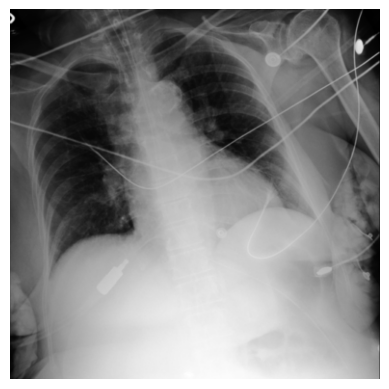

In [10]:
# Display images:
for i, j in enumerate(batch['images']):
    display(f'Study {i+1}:')
    for k in j:
        if not torch.all(k == 0):
            image = k.numpy()
            for channel in range(image.shape[0]):
                image[channel] -= image[channel].min()
                image[channel] /= image[channel].max()
            image = (image * 255).astype(np.uint8)
            plt.imshow(image.transpose(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.show()

In [11]:
# Generate findings only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')]],
    eos_token_id=tokenizer.sep_token_id
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\n') for i in findings]

Findings:
	 30- EXPANSION of the left lung with a 3 chest tube. the left pneumothorax appears to be noticeable, although the pleural drainage tube is not identified. the rest of the study shows no significant changes compared to the x-ray from 12/11. the amount of left chest tube is unchanged. subcutaneous emphysema in the left thoracic wall. right lung re-expansion and left pleural effusion. slight improvement of the atelectasis of the left lung. no other alterations in the right lung. minimal left pneumothorax persists. right pleural drainage without apparent pneumothorax image. right lung re-expansion. small pneumothorax persists in the left lung. left chest tube with distal end at the level of the middle hemithorax. no other alterations. atelectasis of the left lung. central venous line with distal end in the left axillary vein. the distal end of the drainage tube is projected in the upper portion of the left hemithorax at the base of the left hemithorax. no pleural effusion. subcu

In [12]:
# Generate impression only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NI]')]],
    input_ids=torch.tensor([[tokenizer.bos_token_id, tokenizer.convert_tokens_to_ids('[NF]'), tokenizer.sep_token_id]]*mbatch_size, device=device, dtype=torch.long),
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Impression:\n\t{i}\n') for i in impression]

Impression:
	 from cardiac silhouette,. Left chest tube is in place with subcutaneous emphysema at the left base. There is probably a small left apical pneumothorax. Left chest tube is unchanged. There is new subcutaneous emphysema in the left chest wall and left chest wall



In [13]:
# Generate both sections:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')], [tokenizer.convert_tokens_to_ids('[NI]')]],
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\nImpression:\n\t{j}\n') for i,j in zip(findings, impression)]

Findings:
	 post-surgical changes in the left hemithorax. no pneumothorax identified in this examination. no other significant changes compared to the study of the date. no pleural effusion is observed. infiltrate in the right hemithorax. no pneumothorax observed in the right lung. no areas of pulmonary consolidation are identified in the visualized bone structures. subsegmental atelectasis in the left lower lobe. no pleural effusion observed. no changes compared to the radiograph taken on date date date date. bilateral interstitial infiltrates without significant changes compared to the radiograph of the date. atelectasis in the left lung field. central venous line with distal end in the left axilla. no other findings to report. central venous line with distal end in the left axilla. no pleural effusion. conclusion: no significant changes compared to the study of the date. compared to the study of the date, there is a decrease in the size of the left pneumothorax. conclusion: no chang